In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [2]:
# file loader
from os.path import isfile

def load_data(file):
    data = pd.read_csv(file, header=None)
    return data.values

In [3]:
window_size = 75   # 50Hz, 75 samples = 1.5s of movement
window_stride = 25
action_types = ('grenade', 'reload')
data_depth = 6

def load_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    for action_type in action_types:

        for i in range(1, 100, 1):
            # if file exists
            if not isfile(data_dir + f"/{action_type}{i}.csv"):
                break
            data = load_data(data_dir + f"/{action_type}{i}.csv")

            # sliding window
            for j in range(0, len(data) - window_size+1, window_stride):
                dataset_x.append(data[j:j + window_size])
                dataset_y.append(action_types.index(action_type))

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(len(action_types)):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    dataset_x = np.float32(dataset_x)/32
    dataset_y = to_categorical(dataset_y)
    return np.array(dataset_x), np.array(dataset_y)

# load dataset
dataset_x, dataset_y = load_dataset("Dataset")

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, stratify = dataset_y)

# summary of test dataset
test = np.argmax(test_y, axis=1)
print("\nTest set distribution")
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(test.tolist().count(i)) + " samples")


Dataset initialized with size: 58
Class 0 has 11 samples
Class 1 has 47 samples

Test set distribution
Class 0 has 2 samples
Class 1 has 10 samples


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11, 16)            2416      
                                                                 
 dropout (Dropout)           (None, 11, 16)            0         
                                                                 
 flatten (Flatten)           (None, 176)               0         
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 2,770
Trainable params: 2,770
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 115ms/step


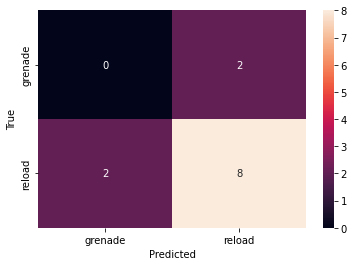

In [4]:
conv1filters = 16
conv1kernel = 25
conv1stride = 5

model = Sequential()
model.add(Conv1D(conv1filters, conv1kernel, strides=conv1stride, activation='relu', input_shape=(window_size, 6)))
model.add(Dropout(0.5)) # 50% dropout
# model.add(Conv1D(32, 40, activation='relu', data_format='channels_first'))
model.add(Flatten())
# model.add(Dense(16, activation='relu'))
model.add(Dense(len(action_types), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# performance before training
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [5]:
# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [6]:
# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 100
    batch_size = 32
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), callbacks = [model_checkpoint_callback, reduce_lr, early_stopping], verbose=verbose)
    _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
    return model

model = train_network(model, train_x, train_y, test_x, test_y)

Epoch 1/100
2/2 [==============================] - 1s 413ms/step - loss: 42.5099 - accuracy: 0.5652 - val_loss: 0.2327 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 195ms/step - loss: 19.9558 - accuracy: 0.6957 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 23ms/step - loss: 10.7749 - accuracy: 0.7826 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 24ms/step - loss: 1.6162 - accuracy: 0.9783 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 22ms/step - loss: 1.4458 - accuracy: 0.9565 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 23ms/step - loss: 1.1174 - accuracy: 0.9348 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 26m

# Draw confusion matrix

1/1 [==============================] - 0s 14ms/step


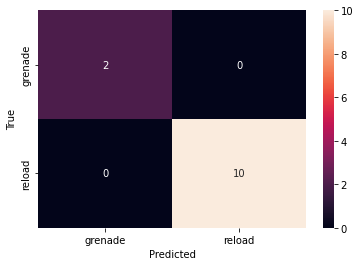

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_weights(checkpoint_filepath)
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [8]:
print(f"window shape: {window_size, data_depth}")
print(f"kernel shape: {conv1kernel, data_depth}")
print(f"first layer weights shape: {model.layers[0].get_weights()[0].shape}")
print(f"first layer output shape: {model.layers[0].output_shape}")
print(f"second layer weights shape: {model.layers[3].get_weights()[0].shape}")
print(f"second layer output shape: {model.layers[3].output_shape}")

window shape: (75, 6)
kernel shape: (25, 6)
first layer weights shape: (25, 6, 16)
first layer output shape: (None, 11, 16)
second layer weights shape: (176, 2)
second layer output shape: (None, 2)


In [25]:
# export weights and biases
layer_names = ["conv1d", 'dense']
for layer in model.layers:
    layer_name = layer.name
    if layer_name not in layer_names:
        continue
    weights = layer.get_weights()
    print(weights[0].shape)
    print(weights[0].reshape(-1).shape)
    print(weights[1].shape)
    with open(f"{layer_name}_w_v1.npy", 'wb') as f:
        np.save(f, weights[0].reshape(-1))
    with open(f"{layer_name}_b_v1.npy", 'wb') as f:
        np.save(f, weights[1])

(25, 6, 16)
(2400,)
(16,)
(176, 2)
(352,)
(2,)


In [23]:
# export test dataset
with open("test_x_v1.npy", 'wb') as f:
    print(test_x.shape)
    np.save(f, test_x)
with open("test_y_v1.npy", 'wb') as f:
    print(test_y.shape)
    np.save(f, np.uint32(np.argmax(test_y, axis = -1)))

(12, 75, 6)
(12, 2)


In [60]:
# directly print out weights and biases
layer_names = ["conv1d", 'dense']

for layer_name in layer_names:
    print(f"extern INPUT_DTYPE model_param_{layer_name}_weights[]")
    print(f"extern INPUT_DTYPE model_param_{layer_name}_biases[]")

for layer in model.layers:
    layer_name = layer.name
    if layer_name not in layer_names:
        continue
    weights = layer.get_weights()
    print(f"INPUT_DTYPE model_param_{layer_name}_weights[] = {{")
    weights_to_be_printed = weights[0].reshape(-1)
    # five values per line
    n_values_per_line = 10
    for i in range(0, len(weights_to_be_printed), n_values_per_line):
        print(", ".join([str(round(x, 10)) for x in weights_to_be_printed[i:i+n_values_per_line]]) + ",")
    print("};")
    print(f"INPUT_DTYPE model_param_{layer_name}_biases[] = {{")
    # print n values per line
    for i in range(0, len(weights[1]), n_values_per_line):
        print(", ".join([str(round(x, 10)) for x in weights[1][i:i+n_values_per_line]]) + ",")
    print("};")

extern INPUT_DTYPE model_param_conv1d_weights[]
extern INPUT_DTYPE model_param_conv1d_biases[]
extern INPUT_DTYPE model_param_dense_weights[]
extern INPUT_DTYPE model_param_dense_biases[]
INPUT_DTYPE model_param_conv1d_weights[] = {
-0.0028426116, -0.0042822533, 0.066316694, -0.02496958, 0.010495311, -0.04512343, -0.020571869, -0.10261642, 0.037253488, -0.06465519,
-0.07016044, 0.001876286, -0.02342298, 0.064841904, -0.10251299, 0.030597825, 0.033835623, -0.06993854, 0.10023402, 0.028452957,
-0.0015291736, -0.08574341, -0.027105939, 0.040597983, 0.072146654, 0.014062835, -0.09299416, 0.08656698, 0.07578229, 0.029366426,
0.0026239327, -0.080835864, 0.03263899, 0.101223715, 0.087243654, 0.07969695, 0.0028282804, -0.06119597, 0.042135775, -0.0042182896,
0.018059101, 0.06589362, -0.0033398631, -0.026983948, 0.09779717, 0.09549167, 0.06417899, -0.06852177, -0.07714562, -0.092479035,
0.006540405, 0.01801672, -0.09669593, -0.024393532, -0.019812828, -0.012019306, 0.045249946, -0.08541149, -0.

In [72]:
# directly print out test dataset
n_values_per_line = 10
dataset_size = test_x.shape[0]
print("#define DATASET_SIZE", dataset_size)

print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(0, test_x.shape[0]):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(round(x, 10)) for x in test_x[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(0, test_x.shape[0]):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

#define DATASET_SIZE 12
const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {
-132.6875, -43.78125, -13.6875, 23.65625, -20.6875, -59.593754,
-136.71875, -49.4375, -11.65625, 28.75, -28.375, -90.125,
-140.8125, -54.53125, -8.96875, 45.34375, -41.53125, -115.90625,
-144.65625, -59.375, -6.5, 64.78125, -59.0625, -149.9375,
-147.90625, -62.5, -4.375, 103.59375, -80.5625, -172.125,
-149.9375, -63.0625, -2.5625, 121.34374, -100.125, -185.34375,
-150.90625, -62.71875, -1.25, 106.34375, -114.78124, -191.84375,
-151.25, -63.59375, -0.46874997, 84.1875, -121.40625, -200.6875,
-151.0, -65.8125, -0.3125, 77.78125, -125.9375, -206.625,
-149.59375, -68.53125, -0.5, 83.40625, -129.53125, -213.40625,
-147.0625, -70.46875, -0.6875, 95.40625, -131.28125, -224.25002,
-141.8125, -71.25, -1.40625, 105.6875, -145.46875, -231.28127,
-136.53125, -70.40625, -1.9375, 102.78125, -141.96875, -224.09375,
-128.09375, -68.96875, -2.90625, 93.625, -140.28125, -214.28125,
-116.5625, -64.4375, -4.40625, 67.7